In [1]:
import App
import os
import pickle

G:\Apps\Conda\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
UserMaker = App.UserMaker
try:
    with open('G:\\Programming\\major\\data\\users.dat', mode='rb') as file:
        UM = pickle.load(file)
except EOFError as E:
    print(E)
DM = App.DatasetMaker(UM)


In [6]:
from models.User import User, UserData, UserType
from models.Tweet import Tweet
from random import shuffle
id = DM.train_users[0].id

all_train_users = DM.train_users
all_test_users = DM.test_users

shuffle(all_train_users)
shuffle(all_test_users)


In [1]:
import numpy as np


In [8]:

def get_user_from_pickle(id):
    with open('G:\\Programming\\major\\data\\processed_data\\' + id + '.dat', 'rb') as file:
        U = pickle.load(file)
    return U

U = get_user_from_pickle(DM.train_users[0].id)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers.recurrent import LSTM
from keras.models import load_model

Using TensorFlow backend.


In [11]:
batch_size=32
num_epochs=20
num_pool=2
num_filters = 128
conv_kernel_width = 3
conv_kernel_height = 200
lstm_output_size= 70
dropout_rate = 0.1


In [12]:
model = Sequential()
model.add(Conv1D(num_filters,
                 conv_kernel_width,
                 padding='valid',
                 activation='relu',
                 strides=1,
                 input_shape=(20,200))) # (32x20x200) -> 
model.add(MaxPooling1D(pool_size=num_pool)) # (32x128x28x200) -> 

model.add(LSTM(lstm_output_size))# 
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu')) # 64
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [13]:

class DataGenerator:
    
    def __init__(self, dim_x = 20, dim_y = 200, batch_size=32, shuffle=True):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.batch_size = batch_size
        self.user_batch_size = 100
        self.shuffle = shuffle
        
    def __get_exploration_order(self, user_list):
        indexes = np.arange(len(user_list))
        
        if self.shuffle == True:
            shuffle(indexes)
        
        return indexes
    
    def get_tweets_from_users(self, user_list):
        vector_forms = []
        labels = []
        
        for user in user_list:
            U = get_user_from_pickle(user.id)
            for tweet in U.tweets:
                vector_forms.append(tweet.vector_form)
                labels.append(U.user_type.value)
        
        imax = int(len(labels) / self.batch_size)
        for i in range(imax):
            temp_tweets = vector_forms[i*self.batch_size:(i+1) * self.batch_size]
            temp_labels = labels[i*self.batch_size : (i+1) * self.batch_size]
            
            x, y = self.__data_generation(temp_tweets, temp_labels)
            yield x,y
    
    def generate(self, user_list):
        while 1:
            exploration_order = self.__get_exploration_order(user_list)
            for i in range(len(user_list)):
                temp_users = [user_list[k] for k in exploration_order[i*self.user_batch_size:
                                                                      (i+1)*self.user_batch_size]]
                for item in self.get_tweets_from_users(temp_users):
                    yield item
                
    def __data_generation(self,  tweets, labels):
        
        X = np.empty((self.batch_size, self.dim_x, self.dim_y))
        Y =  np.empty((self.batch_size), dtype=int)
        
        for i, tweet in enumerate(tweets):
            
            X[i, :, :] = np.array(tweet)
            Y[i] = labels[i]
        
        return X, np_utils.to_categorical(Y, 2)

        
    

In [18]:
params = {
    'dim_x' : 20,
    'dim_y' : 200,
    'batch_size' : 32,
    'shuffle' : True
}
batch_size = 32
DM.train_tweets = sum([user.num_tweets for user in DM.train_users])
DM.test_tweets = sum([user.num_tweets for user in DM.test_users])
validation_generator = DataGenerator(**params).generate(DM.test_users)
training_generator = DataGenerator(**params).generate(DM.train_users)

In [16]:
for item in training_generator:
    x,y = item
    print(x.shape, y.shape)

In [19]:
model.fit_generator(generator = training_generator,
                    steps_per_epoch = DM.train_tweets//batch_size,
                    validation_data = validation_generator,
                    validation_steps = DM.test_tweets//batch_size,
                    epochs=10)

Epoch 1/10
  367/49119 [..............................] - ETA: 5512s - loss: 0.5671 - acc: 0.8145

KeyboardInterrupt: 

In [14]:
model.save('G:\\Programming\\major\\trained_model')

In [81]:

class DataGenerator:
    
    def __init__(self, dim_x = 20, dim_y = 200, batch_size=32, shuffle=True):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.batch_size = batch_size
        self.user_batch_size = 100
        self.shuffle = shuffle
        
    def __get_exploration_order(self, user_list):
        indexes = np.arange(len(user_list))
        
        if self.shuffle == True:
            shuffle(indexes)
        
        return indexes
    
    def get_tweets_from_users(self, user_list):
        vector_forms = []
        labels = []
        
        for user in user_list:
            U = get_user_from_pickle(user.id)
            for tweet in U.tweets:
                vector_forms.append(tweet.vector_form)
                labels.append(U.user_type.value)
        
        imax = int(len(labels) / self.batch_size)
        for i in range(imax):
            temp_tweets = vector_forms[i*self.batch_size:(i+1) * self.batch_size]
            temp_labels = labels[i*self.batch_size : (i+1) * self.batch_size]
            
            x, y = self.__data_generation(temp_tweets, temp_labels)
            yield x,y
    
    def generate(self, user_list):
        while 1:
            exploration_order = self.__get_exploration_order(user_list)
            for i in range(len(user_list)):
                temp_users = [user_list[k] for k in exploration_order[i*self.user_batch_size:
                                                                      (i+1)*self.user_batch_size]]
                for item in self.get_tweets_from_users(temp_users):
                    yield item
                
    def __data_generation(self,  tweets, labels):
        
        X = np.empty((self.batch_size, self.dim_x, self.dim_y))
        Y =  np.empty((self.batch_size), dtype=int)
        
        for i, tweet in enumerate(tweets):
            
            X[i, :, :] = np.array(tweet)
            Y[i] = labels[i]
        
        return X, np_utils.to_categorical(Y, 2)

        

<UserType.HUMAN: 0>

In [70]:
from keras.layers.merge import Concatenate
from keras.layers import Reshape
n_model = []
for i in range(batch_size):
    n_model.append(Sequential())
    n_model[i].add(Conv1D(num_filters,
                     conv_kernel_width,
                     padding='same',
                     activation='relu',
                     strides=1,
                     input_shape=(20,200,)))
    n_model[i].add(MaxPooling1D(pool_size=20))

dim1 = 1
dim2 = 20 / num_pool
dim3 = num_filters


final_model = Sequential()
final_model.add(Merge([m for m in n_model], mode='concat'))
print(final_model.output_shape) # input_shape=[(20,200) for i in range(batch_size)]))#, input_shape=batch_size*num_filters)
final_model.add(LSTM(lstm_output_size))
final_model.add(Dropout(0.1))
final_model.add(Dense(64, activation='relu'))
final_model.add(Dense(2))
final_model.add(Activation('softmax'))
final_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 128)
(None, 1, 4096)


G:\Apps\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [71]:
final_model.fit_generator(generator = training_generator,
                    steps_per_epoch = DM.train_tweets//batch_size,
                    validation_data = validation_generator,
                    validation_steps = DM.test_tweets//batch_size,
                    epochs=10)

Epoch 1/10


ValueError: The model expects 32 input arrays, but only received one array. Found: array with shape (32, 20, 200)

In [74]:
import matplotlib.pyplot as plt


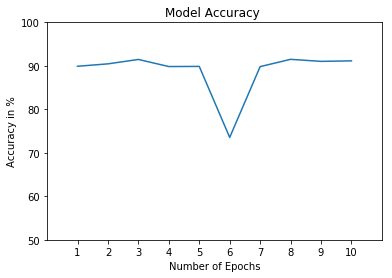

In [88]:
plt.plot([i for i in range(1,11)], [89.9, 90.46, 91.47, 89.84, 89.87, 73.54, 89.82, 91.5, 91.03, 91.15])
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy in %")
plt.title("Model Accuracy ")
plt.axis([0,11,50,100])
plt.xticks([i for i in range(1, 11)])
plt.show()

In [6]:
model = load_model("G:\\Programming\\major\\trained_model")

In [8]:
from vectorize import vectorize
from vectorize import preprocess

In [42]:
tweet = "This is a good thing"
vector_form = vectorize.vectorize_filter(
                preprocess.lemmatize_filter(
                    preprocess.tokenize_filter(tweet)))

In [43]:
import numpy as np
model.predict(np.reshape(np.array(vector_form), (1,20,200)))

array([[ 0.85791105,  0.14208893]], dtype=float32)